# 회고

## 전처리

- 전처리 하는 데 많은 시간을 투자했습니다.
- **기존 데이터셋의 문제**
    - 영화 리뷰에 해당하는 'document' 와 긍부정인지를 판단하는 'label'컬럼으로 이루어진 dataframe을 이용했습니다.
    1. 'document' 컬럼에 중복값이 존재
    2. 같은 'document'지만 다른 label 존재
    3. 설득력이 부족한 label이 존재
- **해결 방안**
    1. 서로 같은 document끼리 label을 판단해서 label 값이 더 빈번한 쪽으로 label을 세팅해주었습니다.
    2. train과 test셋에 document는 같지만 label이 다르다면 제거해주었습니다.
    3. 일부 설득력이 부족한 label을 바꾸어주었습니다.
- **단상**
    - 데이터 전처리가 생각보다 시간이 오래걸리는 영역이라 모델을 공부하고 익히는데 더 많은 시간을 투자해야하지 않았나 하는 아쉬움이 있습니다.

## Text Classification Tasks

- 총 세가지 모델을 사용하였습니다.
    1. LSTM 모델
    2. CNN 모델
    3. LSTM + dropout 모델

## Gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어 분석

- 자체학습된 모델의 레이어를 뽑아와서 임베딩 레이어를 분석하였습니다.
- gensim을 활용하여 사전학습된 레이어의 shape과 유사한 단어추출 과정을 해보았습니다.

## Word2Vec

- word2vec을 활용하여 임베딩 벡터를 만들어 accuracy가 85→87로 상승하였습니다.

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다.
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

### 데이터 로더 구성

    데이터의 중복 제거
    NaN 결측치 제거
    한국어 토크나이저로 토큰화
    불용어(Stopwords) 제거
    사전word_to_index 구성
    텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train, y_train, X_test, y_test, word_to_index 리턴

차례대로 해보자

1. 데이터의 중복 제거

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

### 중복값 제거, labeling
- drop_duplicates()에서 keep을 무조건 맨 위로하면, label이 대세를 따라가지 못할떄가 있다. 다음을 처리해주자

In [3]:
train_data_doc = train_data['document']
sr = train_data_doc.value_counts() > 2
sr2 = test_data['document'].value_counts() > 2
sr = sr[sr]
sr2 = sr2[sr2]
prac = train_data.copy()
prac2 = test_data.copy()

In [4]:
label_dict = {}
temp_dict = {}
test_label_dict = {}
test_temp_dict = {}

In [5]:
for x in sr.index:
    _df = train_data[train_data['document'] == x]
    label_cand = _df['label'].value_counts()
    if len(label_cand.values) == 1:
        label_dict[x] = _df['label'].value_counts().index[0]
    elif label_cand.values[1] / (label_cand.values[0] + label_cand.values[1]) < 0.3:
        label_dict[x] = _df['label'].value_counts().index[0]
    else:
        temp_dict[x] = _df['label'].value_counts().index[0]

In [6]:
for x in sr2.index:
    _df = test_data[test_data['document'] == x]
    label_cand = _df['label'].value_counts()
    if len(label_cand.values) == 1:
        test_label_dict[x] = _df['label'].value_counts().index[0]
    elif label_cand.values[1] / (label_cand.values[0] + label_cand.values[1]) < 0.3:
        test_label_dict[x] = _df['label'].value_counts().index[0]
    else:
        test_temp_dict[x] = _df['label'].value_counts().index[0]


In [7]:
prac.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
prac2.drop_duplicates(subset=['document'], inplace=True, ignore_index=True)
for key, val in label_dict.items():
    prac[prac['document'] == key]['label'] = val
for key, val in test_label_dict.items():
    prac2[prac2['document'] == key]['label'] = val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
prac[prac['document'] == 'good']['label'] = 1
prac[prac['document'] == '재밌게 잘 보았습니다.']['label'] = 1
prac[prac['document'] == '재밋네요']['label'] = 1
prac[prac['document'] == '너무 재미있음']['label'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [9]:
prac2[prac2['document'] == 'good']['label'] = 1
prac2[prac2['document'] == '멋지다']['label'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### ENHANCE

train_data와 test_data에 묘사가 같지만 라벨링이 다른 것 찾아서 제거하기

In [10]:
print(len(prac), len(prac2))

146183 49158


In [11]:
prac[prac['document'] == '굿']['label'].values[0]

1

In [12]:
prac[prac['document'] == 'hsdhksd'].empty

True

In [13]:
for key in temp_dict.keys():
    if prac[prac['document'] == key].empty | prac2[prac2['document'] == key].empty:
        continue
    if prac[prac['document'] == key]['label'].values[0] != prac2[prac2['document'] == key]['label'].values[0]:
        prac = prac[prac['document'] != key]
        prac2 = prac2[prac2['document'] != key]

for key in test_temp_dict.keys():
    if prac[prac['document'] == key].empty | prac2[prac2['document'] == key].empty:
        continue
    if prac[prac['document'] == key]['label'].values[0] != prac2[prac2['document'] == key]['label'].values[0]:
        prac = prac[prac['document'] != key]
        prac2 = prac2[prac2['document'] != key]

In [14]:
for key in label_dict.keys():
    if prac[prac['document'] == key].empty | prac2[prac2['document'] == key].empty:
        continue
    if prac[prac['document'] == key]['label'].values[0] != prac2[prac2['document'] == key]['label'].values[0]:
        prac = prac[prac['document'] != key]
        prac2 = prac2[prac2['document'] != key]

In [15]:
for key in test_label_dict.keys():
    if prac[prac['document'] == key].empty | prac2[prac2['document'] == key].empty:
        continue
    if prac[prac['document'] == key]['label'].values[0] != prac2[prac2['document'] == key]['label'].values[0]:
        prac = prac[prac['document'] != key]
        prac2 = prac2[prac2['document'] != key]

In [16]:
train_data = prac
test_data = prac2

In [17]:
train_data.dropna(how='any', inplace=True)
test_data.dropna(how='any', inplace=True)

In [18]:
train = train_data.copy()
test = test_data.copy()

In [19]:
X_train = []
for sentence in train['document']:
    temp_X = tokenizer.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [20]:
X_train[:10]

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠',
  '.',
  '..',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '.',
  '...',
  '오버',
  '연기',
  '조차',
  '가볍',
  '지',
  '않',
  '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '.', '.', '솔직히', '재미', '없', '다', '.', '.', '평점', '조정'],
 ['사이몬페그',
  '익살',
  '스런',
  '연기',
  '돋보였',
  '던',
  '영화',
  '!',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '너무나',
  '이뻐',
  '보였',
  '다'],
 ['막',
  '걸음마',
  '뗀',
  '3',
  '세',
  '부터',
  '초등',
  '학교',
  '1',
  '학년',
  '생',
  '인',
  '8',
  '살',
  '용',
  '영화',
  '.',
  'ㅋㅋㅋ',
  '.',
  '..',
  '별반',
  '개',
  '아까움',
  '.'],
 ['원작', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다', '.'],
 ['별',
  '반개',
  '아깝',
  '다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '몇',
  '년',
  '인지',
  '.',
  '.',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫',
  '겟',
  '다',
  '납치',
  '.',
  '감금',
  '만',
  '반복',
  '반복',
  '.',
  '.',
  '드라마',
  '가족',
  '없',
  '다

In [21]:
words = np.concatenate(X_train).tolist()
words[:10]

['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리']

In [22]:
counter = Counter(words)

In [23]:
counter = counter.most_common(10)

In [24]:
vocab = ['', '', '', ''] + [key for key, _ in counter]
vocab

['', '', '', '', '.', '영화', '다', '고', '하', '을', '보', '..', '게', ',']

In [25]:
word_to_index = {word:index for index, word in enumerate(vocab)}
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13}

In [26]:
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

In [27]:
def load_data(train_data, test_data, num_words=10000):

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [28]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [29]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

146146 146146 49121 49121


In [30]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [31]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.974388913641322
문장길이 최대 :  116
문장길이 표준편차 :  12.843248954773248
pad_sequences maxlen :  41
전체 문장의 0.9342746086128224%가 maxlen 설정값 이내에 포함됩니다. 


In [32]:
x_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                     value=word_to_index["<PAD>"],
                                                     padding='pre', # 혹은 'pre'
                                                     maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre', # 혹은 'pre'
                                                    maxlen=maxlen)

print(x_train.shape)

(146146, 41)


1. LSTM 모델

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
HIDDEN_SIZE = 512

model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim))
model.add(keras.layers.LSTM(HIDDEN_SIZE))
model.add(keras.layers.Dense(8, 'relu'))
model.add(keras.layers.Dense(1, 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1083392   
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,247,505
Trainable params: 1,247,505
Non-trainable params: 0
_________________________________________________________________


In [34]:
# validation set 25000건 분리
x_val = x_train[:25000]
y_val = y_train[:25000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[25000:]
partial_y_train = y_train[25000:]

In [35]:
x_val[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   32,   74,
         919,    4,    4,   39,  228,   20,   33,  748],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1028,    4,   11,  519,  549,  687,    5,  120,    4,
          69, 1639,   52,  925, 1006,   15,   44,  391],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   24,  205,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  

In [36]:
print(partial_x_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(121146, 41)
(121146,)
(25000, 41)
(25000,)


In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
237/237 [==============================] - 27s 103ms/step - loss: 0.6073 - accuracy: 0.6592 - val_loss: 0.3573 - val_accuracy: 0.8463

In [38]:
history_dict = history.history

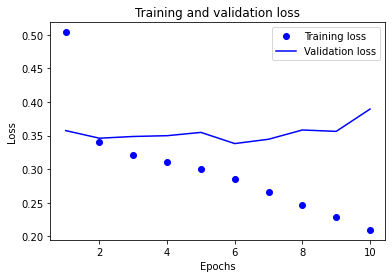

In [39]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

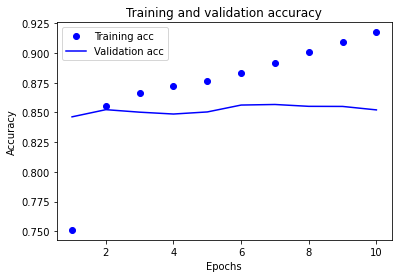

In [40]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

2. CNN 모델

In [41]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
237/237 [==============================] - 8s 20ms/step - loss: 0.5973 - accuracy: 0.6621 - val_loss: 0.3590 - val_accuracy: 0.8433

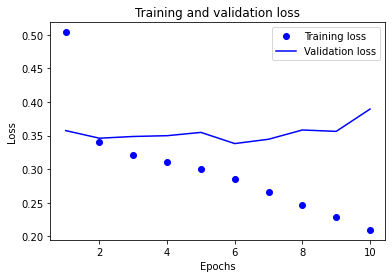

In [43]:

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

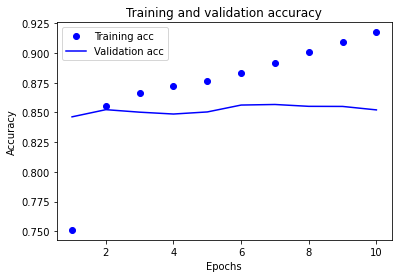

In [44]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3. LSTM 모델 with dropout

In [68]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
HIDDEN_SIZE = 512

model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim))
model.add(keras.layers.LSTM(HIDDEN_SIZE, dropout=0.5))
model.add(keras.layers.Dense(8, 'relu'))
model.add(keras.layers.Dense(1, 'sigmoid'))

model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1083392   
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 4104      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,247,505
Trainable params: 1,247,505
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
237/237 [==============================] - 27s 104ms/step - loss: 0.6180 - accuracy: 0.6548 - val_loss: 0.3658 - val_accuracy: 0.8417

오 잘나오는것같다

## gensim의 유사단어 찾기 활용 비교
1. 자체학습

In [73]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


10000개의 단어를 16차원으로 학습시켰기에 다음과 같은 shaepd이 출력됨

In [84]:
index_to_word[30]

'음'

In [85]:
weights[30]

array([ 0.05453073, -0.00489912, -0.02094804,  0.05017186, -0.0169113 ,
        0.05102859, -0.00055063, -0.01507857,  0.00011342, -0.04544633,
       -0.01973297, -0.02176607,  0.04284023,  0.00016546,  0.00139203,
        0.04834063], dtype=float32)

위와 같은 식으로 index에 해당하는 vector와 word를 매칭할 수 있음
2. 사전학습

In [86]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-0.01228145, -0.4937083 ,  0.4424771 , -1.0789338 , -1.0551587 ,
       -0.8106456 , -0.0881472 ,  0.7738013 , -0.3837249 , -0.31405708,
        0.18792619, -0.04978764,  0.3977235 ,  1.0052139 , -0.5921918 ,
        0.57315415, -0.13287784,  1.4190367 ,  0.5338879 ,  0.08187074,
       -0.21017547, -0.31960285,  0.08991678, -0.06743078,  0.14399454,
        0.04861213,  0.4904712 ,  0.38203648, -0.33213428, -0.48618734,
       -0.6996383 , -0.48903087, -0.5666092 ,  0.11454912,  0.7527777 ,
       -1.6491356 ,  0.709264  ,  0.14231981,  1.2408166 ,  0.9104645 ,
        1.0235597 , -0.7135743 , -0.5323588 , -0.16439462, -0.12318534,
       -0.41341293,  0.76286334, -0.24337888, -1.0924134 , -0.78981435,
        0.24504295, -0.472915  , -0.17546178,  0.10006592, -1.2155428 ,
        0.4059387 ,  0.8259838 , -0.18593056, -0.21122731, -0.46615708,
        0.74433243, -0.18605745, -0.9175297 ,  0.08531424,  0.09134697,
       -0.60375917,  0.5236646 ,  0.7689134 ,  0.19123535,  0.60

In [88]:
vector = word2vec['음']
vector     # 무려 300dim의 워드 벡터입니다.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.6913005 , -2.1170197 , -1.1935515 ,  2.0576053 ,  1.2880217 ,
       -2.0489879 , -0.35903174, -1.0804672 , -0.8489353 ,  0.4989537 ,
       -1.842057  ,  2.2466395 , -0.8651566 ,  1.7187246 , -0.2983146 ,
        1.2401271 ,  2.4678612 ,  0.34646386,  1.2250557 , -0.4344142 ,
       -1.7769375 , -2.4605088 , -2.0425546 , -0.58069444,  1.8670741 ,
        0.44323367, -0.5525048 , -2.1041877 , -2.054358  ,  0.23922233,
        0.2662293 ,  1.6334274 ,  0.25801897,  0.6596649 ,  1.6300476 ,
       -1.1588416 ,  0.87613523, -1.6657709 ,  2.091163  ,  1.0270036 ,
       -1.4648329 , -1.5326371 ,  1.9958264 , -0.31091145, -1.0158806 ,
        0.91703594,  0.28044254,  2.760456  , -0.7077753 , -0.19447689,
        0.23760837,  0.7333937 ,  1.3512338 , -0.6303867 ,  0.90229464,
        3.300013  , -0.96211374, -2.3832119 , -1.895855  ,  0.19984373,
       -3.291454  ,  3.1144557 , -0.03530932, -0.298347  ,  1.4213417 ,
       -1.2662352 ,  3.3668382 ,  3.3730786 ,  0.04519241, -0.53

In [87]:
word2vec.similar_by_word("음")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('으므로', 0.5254330635070801),
 ('으면', 0.5184401273727417),
 ('다고', 0.5068936347961426),
 ('다면', 0.5056914687156677),
 ('다는', 0.490048885345459),
 ('으니', 0.4864504337310791),
 ('습니다', 0.4698779582977295),
 ('다', 0.463430255651474),
 ('있음', 0.4566175639629364),
 ('는지', 0.4555988609790802)]

사전학습된 word2vec같은 경우는 훨씬 많은 300차원의 가중치를 사용.

In [ ]:
import os

In [49]:
index_to_word = {index:word for word, index in word_to_index.items()}

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors['굿']

array([-0.15632698, -0.15453583,  0.16034834,  0.13932009, -0.17164269,
       -0.12219524,  0.14117162,  0.05708749, -0.11835008,  0.12345603,
        0.12409917,  0.22074366, -0.20371073,  0.1751914 , -0.14795376,
       -0.13826247], dtype=float32)

In [51]:
word_vectors.similar_by_word("별로")

[('어설픈', 0.9860494136810303),
 ('졸작', 0.9828450083732605),
 ('22', 0.9776939153671265),
 ('아녀', 0.9773950576782227),
 ('실망', 0.9761337041854858),
 ('늘어진다', 0.9757893085479736),
 ('쥐어짜', 0.9750790596008301),
 ('왜곡', 0.974817156791687),
 ('고리타분', 0.974601686000824),
 ('돌려줘', 0.9741437435150146)]

In [52]:
!pip install --upgrade gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [53]:
import gensim

In [54]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['재미']
vector     # 무려 300dim의 워드 벡터입니다.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-0.01228145, -0.4937083 ,  0.4424771 , -1.0789338 , -1.0551587 ,
       -0.8106456 , -0.0881472 ,  0.7738013 , -0.3837249 , -0.31405708,
        0.18792619, -0.04978764,  0.3977235 ,  1.0052139 , -0.5921918 ,
        0.57315415, -0.13287784,  1.4190367 ,  0.5338879 ,  0.08187074,
       -0.21017547, -0.31960285,  0.08991678, -0.06743078,  0.14399454,
        0.04861213,  0.4904712 ,  0.38203648, -0.33213428, -0.48618734,
       -0.6996383 , -0.48903087, -0.5666092 ,  0.11454912,  0.7527777 ,
       -1.6491356 ,  0.709264  ,  0.14231981,  1.2408166 ,  0.9104645 ,
        1.0235597 , -0.7135743 , -0.5323588 , -0.16439462, -0.12318534,
       -0.41341293,  0.76286334, -0.24337888, -1.0924134 , -0.78981435,
        0.24504295, -0.472915  , -0.17546178,  0.10006592, -1.2155428 ,
        0.4059387 ,  0.8259838 , -0.18593056, -0.21122731, -0.46615708,
        0.74433243, -0.18605745, -0.9175297 ,  0.08531424,  0.09134697,
       -0.60375917,  0.5236646 ,  0.7689134 ,  0.19123535,  0.60

In [55]:
word2vec.similar_by_word("재미")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [56]:
len(index_to_word)

10000

In [58]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [59]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [60]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/20
237/237 [==============================] - 12s 39ms/step - loss: 0.6545 - accuracy: 0.5927 - val_loss: 0.4440 - val_accuracy: 0.7930

KeyboardInterrupt: 

In [62]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
HIDDEN_SIZE = 512

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen,
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(HIDDEN_SIZE, dropout=0.5))
model.add(keras.layers.Dense(8, 'relu'))
model.add(keras.layers.Dense(1, 'sigmoid'))

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 3,464,337
Trainable params: 3,464,337
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
237/237 [==============================] - 35s 141ms/step - loss: 0.5686 - accuracy: 0.6924 - val_loss: 0.4228 - val_accuracy: 0.8036

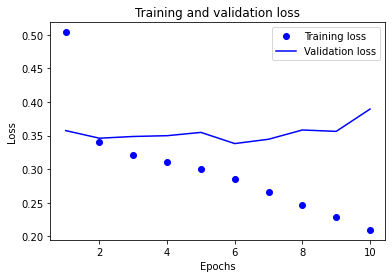

In [64]:

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

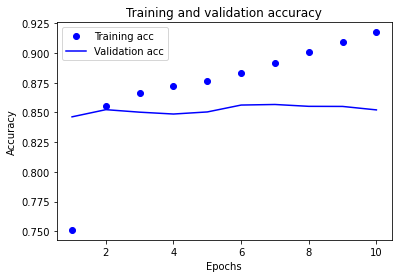

In [65]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()